In [33]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Config

In [34]:
from config import dir_config, main_config

raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)

mds_updrs_conf = main_config.MDS_UPDRS

### Import Data

In [35]:
session_metadata = pd.read_csv(Path(processed_dir, "processed_metadata_accu_60.csv"), index_col=None)

In [36]:
# replace categorical values with integers
session_metadata['Were_Diskinesias_Present'] = session_metadata['Were_Diskinesias_Present'].map({'yes': 1, 'no': 0})
session_metadata['Did_these_Movements_Interfere_with_Ratings'] = session_metadata['Did_these_Movements_Interfere_with_Ratings'].map({'yes': 1, 'no': 0})

### Score Calculation

1. Calculate total UPDRS scores

In [37]:
session_metadata.keys()

Index(['subject_id', 'prior_condition', 'treatment', 'off_med_first',
       'is_tremor_dominant', 'bradykinesia_score', 'sMMSE', 'BDI', 'BAI',
       'UPDRS', '210_Tremor', '301_Speech', '302_Facial_Expression',
       '303a_Rigidity_Neck', '303b_Rigidity_RUE', '303c_Rigidity_LUE',
       '303d_Rigidity_RLE', '303e_Rigidity_LLE', '304a_Finger_Tapping_RUE',
       '304b_Finger_Tapping_LUE', '305a_Hand_Movements_RUE',
       '305b_Hand_Movements_LUE', '306a_Pronation_Subination_Movements_RUE',
       '306b_Pronation_Subination_Movements_LUE', '307a_Toe_Tapping_RLE',
       '307b_Toe_Tapping_LLE', '308a_Leg_Agility_RLE', '308b_Leg_Agility_LLE',
       '309_Arising_from_Chair', '310_Gait', '311_Freezing_of_Gait',
       '312_Postural_Stability', '313_Posture',
       '314_Global_Spontaneity_of_Movement', '315a_Posture_Tremor_RUE',
       '315b_Posture_Tremor_LUE', '316a_Kinetic_Tremor_RUE',
       '316b_Kinetic_Tremor_LUE', '317a_Rest_Tremor_Amplitude_RUE',
       '317b_Rest_Tremor_Amplit

2. Calculate Tremor and Bradykinesia Scores

In [38]:
# Extract the relevant tremor variables that exist in the DataFrame columns
relevant_tremor_vars = [var for var in mds_updrs_conf.TREMOR_ITEMS if var in session_metadata.columns]
relevant_bradykinesia_vars = [var for var in mds_updrs_conf.BRADYKINESIA_ITEMS if var in session_metadata.columns]

for sub in session_metadata['subject_id'].unique():
    # get indices of the subject
    idx = session_metadata[session_metadata['subject_id'] == sub].index
    # get index where treatment is off
    off_idx = session_metadata[(session_metadata['subject_id'] == sub) & (session_metadata['treatment'] == 'OFF')].index
    tremor_score = np.nanmean(session_metadata.loc[off_idx, relevant_tremor_vars], axis=1)
    bradykinesia_score = np.nanmean(session_metadata.loc[off_idx, relevant_bradykinesia_vars], axis=1)
    categorization_score = tremor_score / bradykinesia_score
    # adding to metadata
    session_metadata.loc[idx, 'tremor_score'] = tremor_score[0]
    session_metadata.loc[idx, 'bradykinesia_score'] = bradykinesia_score[0]
    session_metadata.loc[idx, 'categorization_score'] = categorization_score[0]

# save the session_metadata['categorization'] equal to tremor_dominant if the score is greater than 1, bradykinesia_dominant if the score is less than 0.8 and intermediate if the score is between 0.8 and 1
session_metadata['categorization'] = np.NaN
session_metadata.loc[session_metadata['categorization_score'] >= 1, 'categorization'] = 'tremor_dominant'
session_metadata.loc[session_metadata['categorization_score'] <= 0.8, 'categorization'] = 'bradykinesia_dominant'
session_metadata.loc[(session_metadata['categorization_score'] > 0.8) & (session_metadata['categorization_score'] <= 1), 'categorization'] = 'intermediate'


print(f"All subjects \n {session_metadata['categorization'].value_counts()} \n\n Valid subjects \n {session_metadata['categorization'].value_counts()}")

print(session_metadata.groupby('subject_id')['categorization'].value_counts())

All subjects 
 categorization
tremor_dominant          16
bradykinesia_dominant    14
intermediate              2
Name: count, dtype: int64 

 Valid subjects 
 categorization
tremor_dominant          16
bradykinesia_dominant    14
intermediate              2
Name: count, dtype: int64
subject_id  categorization       
P1          bradykinesia_dominant    2
P11         tremor_dominant          2
P12         tremor_dominant          2
P13         bradykinesia_dominant    2
P16         tremor_dominant          2
P17         intermediate             2
P18         bradykinesia_dominant    2
P19         tremor_dominant          2
P20         bradykinesia_dominant    2
P22         bradykinesia_dominant    2
P23         bradykinesia_dominant    2
P24         tremor_dominant          2
P4          tremor_dominant          2
P6          tremor_dominant          2
P7          tremor_dominant          2
P9          bradykinesia_dominant    2
Name: count, dtype: int64


### Assess scores

(-0.1, 2.0)

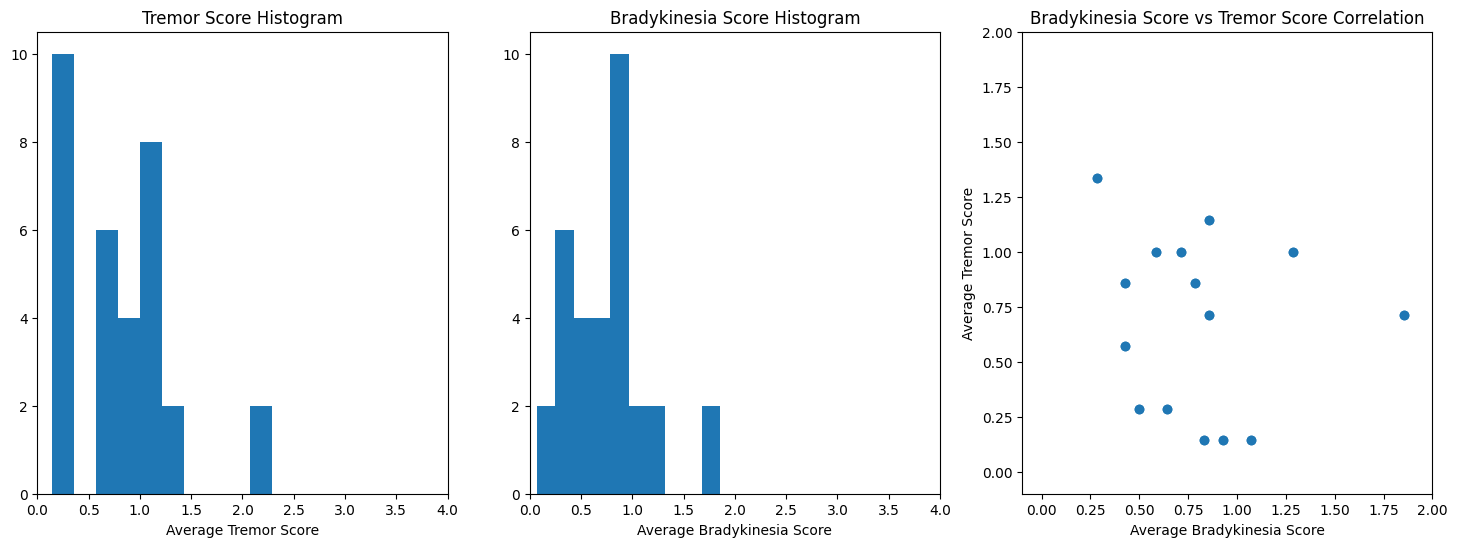

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].hist(session_metadata['tremor_score']),
ax[0].set_title('Tremor Score Histogram')
ax[0].set_xlabel('Average Tremor Score')
ax[0].set_xlim(0, 4)
ax[1].hist(session_metadata['bradykinesia_score'])
ax[1].set_title('Bradykinesia Score Histogram')
ax[1].set_xlabel('Average Bradykinesia Score')
ax[1].set_xlim(0, 4)
ax[2].plot(session_metadata['bradykinesia_score'], session_metadata['tremor_score'], 'o')
ax[2].set_title('Bradykinesia Score vs Tremor Score Correlation')
ax[2].set_xlabel('Average Bradykinesia Score')
ax[2].set_ylabel('Average Tremor Score')
ax[2].set_xlim(-0.1, 2)
ax[2].set_ylim(-0.1, 2)

Old vs New UPDRS

### Save data and data results (metadata)

In [40]:
session_metadata.to_csv(Path(processed_dir, "processed_metadata_accu_60.csv"), index=False)